## Sample script to learn a PDE parameter in training

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from neural_diff_eq.problem import Variable, Parameter
from neural_diff_eq.setting import Setting
from neural_diff_eq.problem.domain import (Rectangle,
                                           Interval)
from neural_diff_eq.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from neural_diff_eq.models.fcn import SimpleFCN
from neural_diff_eq import PINNModule
from neural_diff_eq.utils import laplacian, gradient
from neural_diff_eq.utils.fdm import FDM, create_validation_data
from neural_diff_eq.utils.plot import Plotter
from neural_diff_eq.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from neural_diff_eq.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()


True

We define some parameters that describe the setting:

In [2]:
w, h = 10, 10
t0, tend = 0, 3
temp_hot = 100

We define the independent variables of the PDE, which will later determine the inputs to the NN. Every variable has a domain and can have one or more boundary conditions.

Now we also define a Parameter which will be optimized during training, based on given training data.

In [3]:
x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[w, 0],
                              corner_tl=[0, h]),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

# Achtung: bisher muss hier das device für die Parameter von Hand gesetzt werden
device = 'cuda' if torch.cuda.is_available() else 'cpu'
m = torch.Tensor((0.0,)).to('cuda')
D = Parameter(init=m, name='D')

Using the same notation, as in the forward problem, we can define a PDE-condition to the inner of the domain.

Here we also include the parameter 'D' in the (dummy) equation, that should be computed. Therefore the pde-condition gets now an additional input: params. This input contains all learnable paramters of the model.

In [4]:
norm = torch.nn.MSELoss()

def pde(u, input, params):
    return gradient(u, input['t']) - params['D']*laplacian(u, input['x'])

train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             sampling_strategy='random',
                             weight=1.0,
                             dataset_size=500,
                             data_plot_variables=('x','t'))

Instead of adding addtional conditions for the inital and boundary values we now create a DataCondition, by using a FDM to solve the forward problem.

In [5]:
D_list = [2] # This D is the value we will later try to find!
domain_dic = {'x': [[0,w], [0,h]]}
dx, dy = 0.5, 0.5
step_width_dict = {'x': [dx, dy]}
time_interval = [t0, tend]
def inital_condition(input):
    return temp_hot * np.sin(np.pi/w*input['x'][:,:1]) * np.sin(np.pi/h*input['x'][:,1:]) 
fdm_start = timer()
domain, time, u = FDM(domain_dic, step_width_dict, time_interval, 
                      D_list, inital_condition)
fdm_end = timer()
print('Time for FDM-Solution:', fdm_end-fdm_start)

data_x, data_u = create_validation_data(domain, time, u, D_list, D_is_input = False)

Time for FDM-Solution: 0.010123017244040966


We dont want to use all points of the FDM-solution, therefore for now pick only 5000 random values 

In [6]:
index = np.random.choice(len(data_u), 5000, replace=False)
data_u = data_u[index]
for name in data_x:
    data_x[name] = data_x[name][index]

With these points we now create a DataCondition

In [7]:
data_cond = DataCondition(data_x=data_x,
                         data_u=data_u,
                         name='data_cond',
                         norm=norm)

As always the variables as well as the conditions for the inner part of the domain are collected in a Setting. Now we also add the parameters that should be trained in a dictonary:

In [8]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond, 'data': data_cond},
                val_conditions={},
                n_iterations=500,
                parameters={'D': D})

To solve the problem we use (like always) the PINNModule 

In [9]:
solver = PINNModule(model=SimpleFCN(input_dim=3, depth=3, width=20),
                    optimizer=torch.optim.Adam, # Start with adam
                    lr=1e-2
                    )

Finally, we define a lightning trainer and train the model. 

In [10]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=1,
                     max_epochs=4,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
setup:  cpu
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a 

Training: 0it [00:00, ?it/s]

In [11]:
setup.parameters['D']

Parameter containing:
tensor([1.9015], device='cuda:0', requires_grad=True)

In [12]:
# switch to lbfgs
solver.lr = 0.05
solver.optim_params = {'max_iter': 1, 'history_size': 100}
solver.optimizer = torch.optim.LBFGS
trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=100,
                     max_epochs=3,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

And again check the value of D. It is pretty close to D = 2, what we used in the FDM 

In [13]:
setup.parameters['D']

Parameter containing:
tensor([2.0007], device='cuda:0', requires_grad=True)

Not only did we find D, the neural network also learned the solution of our problem:

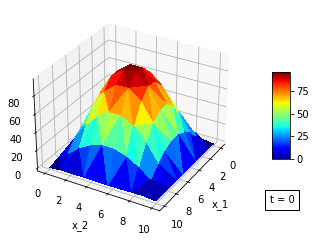

In [14]:
from neural_diff_eq.utils.plot import _plot
fig = _plot(solver.model, plot_variables=x, points=100, dic_for_other_variables={'t': 0})